In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
BACKBONE = 'mobilenetv2'

In [4]:
heigh = 320

In [5]:
class datasetcreator:
   def __init__(self,preprocess) -> None:
      self.preprocess = preprocess

   def get_mask(self,image):
      return tf.strings.split(image,os.path.sep)[-1]

   def process_image_with_mask(self,file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image)
      mask = self.maskspath + self.get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      cond = tf.greater_equal(mask,1)
      mask = tf.where(cond,1,0)
      image = tf.cast(image,tf.uint8)
      mask = tf.cast(mask,tf.uint8)
      return image,mask
   
   def aug_fn(self,image, mask):
      image = image[:,:,:3]
      data = {"image":image,"mask":mask}
      aug_data = self.transforms(**data)
      image = aug_data["image"]
      mask = aug_data["mask"]
      image = tf.cast(image, tf.float32)
      mask = tf.cast(mask, tf.float32)
      image = self.preprocess(image)
      return image,mask
   
   def process_data(self,image, mask):
    image,mask = tf.numpy_function(self.aug_fn,inp = (image,mask),Tout=(tf.float32,tf.float32))
    return image, mask

   def __call__(self,imagepath,maskspath,transforms):
      self.transforms = transforms
      self.maskspath = maskspath
      dataset = tf.data.Dataset.list_files(imagepath)
      dataset = dataset.map(self.process_image_with_mask)
      dataset = dataset.map(self.process_data)
      return dataset.batch(4)

In [6]:
dataset = datasetcreator(sm.get_preprocessing(BACKBONE))

In [7]:
valdata = dataset('crosval/val/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))
len(valdata)

3

In [8]:
testaugmentation = albu.Compose([
    albu.Resize(heigh,heigh,always_apply=True),
    albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    albu.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

In [9]:
traindata = dataset('crosval/train/*png','castom-masks/masks_machine/',testaugmentation)
len(traindata)

11

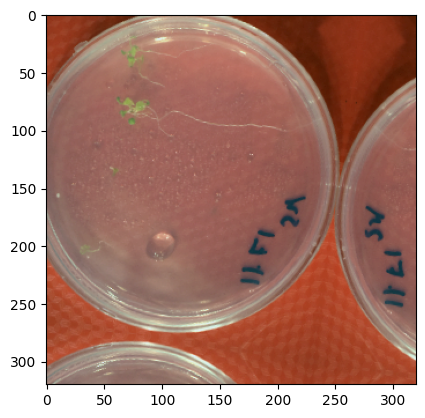

tf.Tensor([], shape=(0,), dtype=float32)


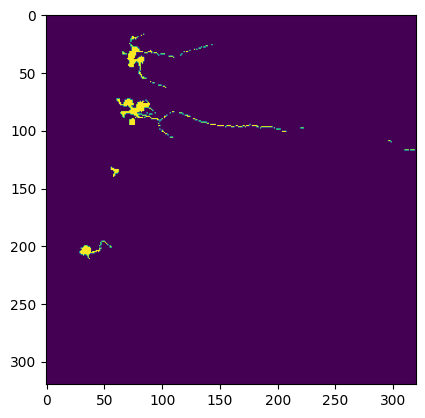

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(mask[mask > 1])

In [11]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
#tf.keras.utils.plot_model(model)

In [13]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 10 and epoch % 5 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='libbestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [14]:
# fit model
model_history = model.fit(
    traindata,
    epochs=60,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60
11/11 [==============================] - ETA: 0s - loss: 1.3582 - iou_score: 0.0132
Epoch 1: val_loss improved from inf to 1.26222, saving model to libbestmodel/
INFO:tensorflow:Assets written to: libbestmodel/assets


INFO:tensorflow:Assets written to: libbestmodel/assets


11/11 [==============================] - 22s 2s/step - loss: 1.3582 - iou_score: 0.0132 - val_loss: 1.2622 - val_iou_score: 6.0642e-06 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
11/11 [==============================] - ETA: 0s - loss: 1.1458 - iou_score: 0.0268
Epoch 2: val_loss improved from 1.26222 to 1.24667, saving model to libbestmodel/


KeyboardInterrupt: 

In [ ]:
testdata = dataset('crosval/test/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))

In [ ]:
results = model.evaluate(testdata)
results

1/1 [==============================] - 1s 543ms/step - loss: 0.7683 - iou_score: 0.2829


[0.768323540687561, 0.2829296886920929]

In [ ]:
i = 0
for img in testdata.take(len(testdata)):
    for image in img[0]:
        mask = model.predict((tf.reshape(image,[1,heigh,heigh,3])))
        mask = tf.keras.utils.array_to_img(mask[0])
        img = tf.keras.utils.array_to_img(image)
        img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
        vis = np.concatenate((img, mask), axis=1)
        i+=1
        cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 31ms/step
